## Import Libraries and Dependencies

In [152]:
# Import our dependencies
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

import tensorflow as tf

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [153]:
# Load the data
file_path = Path("resources/processed_stroke_db_w_cat.csv")
df = pd.read_csv(file_path, index_col=[0])
print(df.shape)
df

(4909, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


## Process Data

### One-hot Encoding for Categotical Data & StandScaler for Numerical Data

In [154]:
# Generate categorical variable list
cat_labels= df.dtypes[df.dtypes == "object"].index.tolist()
print(cat_labels)

# Check the number of unique values in each column
print(df[cat_labels].nunique())

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
gender            3
ever_married      2
work_type         5
Residence_type    2
smoking_status    4
dtype: int64


In [155]:
# Create the OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(df[cat_labels]))

encode_df.index = df.index

# Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names(cat_labels)
print(encode_df.shape)
encode_df.head()

(4909, 16)


,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
id,,,,,,,,,,,,,,,,
9046,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
31112,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
60182,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1665,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
56669,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [156]:
# Merge one-hot encoded features and drop the originals
df = df.merge(encode_df,left_index=True, right_index=True)
df = df.drop(cat_labels,1)
df.shape

C:\Users\Kristen\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


(4909, 22)

### Split, Oversample, Resample Data

In [157]:
# Split the preprocessed data into the features and target arrays
y = df["stroke"].values
X = df.drop(["stroke"],1).values

C:\Users\Kristen\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [158]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12, stratify=y)

In [159]:
# Create the StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_train_scaled.shape

(3681, 21)

In [160]:
# Apply sampling technique to balance the minority class

# Option One: Resample the training data with SMOTE- Instantiate the model
# smote = SMOTE(random_state=1)


# Option Two: Resample the training data with ADASYN- Instantiate the model
smote = ADASYN(random_state=1)


# Resample the targets
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)
Counter(y_resampled)

Counter({0: 3524, 1: 3542})

## Single Neuron / Single Layer Neural Network

### Train, Fit, Evaluate, Predict Model

In [161]:
# Create the Keras Sequential model
nn_model = tf.keras.models.Sequential()

# Add our first Dense layer, including the input layer
nn_model.add(tf.keras.layers.Dense(units=1, activation="relu", input_dim=21))

# Add the output layer that uses a probability activation function
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the Sequential model
nn_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 1)                 22        
                                                                 
 dense_22 (Dense)            (None, 1)                 2         
                                                                 
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________


In [162]:
# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [163]:
# Fit the model to the training data
fit_model = nn_model.fit(X_resampled, y_resampled, validation_data = (X_test_scaled, y_test), epochs=100)

Epoch 1/100
221/221 [==============================] - 1s 1ms/step - loss: 0.7525 - accuracy: 0.5270 - val_loss: 0.8123 - val_accuracy: 0.6515
Epoch 2/100
221/221 [==============================] - 0s 1ms/step - loss: 0.6772 - accuracy: 0.6026 - val_loss: 0.7155 - val_accuracy: 0.7296
Epoch 3/100
221/221 [==============================] - 0s 1ms/step - loss: 0.6331 - accuracy: 0.6850 - val_loss: 0.6969 - val_accuracy: 0.7386
Epoch 4/100
221/221 [==============================] - 0s 1ms/step - loss: 0.5831 - accuracy: 0.7750 - val_loss: 0.6769 - val_accuracy: 0.7337
Epoch 5/100
221/221 [==============================] - 0s 1ms/step - loss: 0.5579 - accuracy: 0.7829 - val_loss: 0.6418 - val_accuracy: 0.7443
Epoch 6/100
221/221 [==============================] - 0s 1ms/step - loss: 0.5424 - accuracy: 0.7840 - val_loss: 0.6164 - val_accuracy: 0.7533
Epoch 7/100
221/221 [==============================] - 0s 1ms/step - loss: 0.5308 - accuracy: 0.7873 - val_loss: 0.5919 - val_accuracy: 0.7581

Epoch 58/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4641 - accuracy: 0.7853 - val_loss: 0.4740 - val_accuracy: 0.7598
Epoch 59/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4642 - accuracy: 0.7856 - val_loss: 0.4710 - val_accuracy: 0.7598
Epoch 60/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4641 - accuracy: 0.7866 - val_loss: 0.4600 - val_accuracy: 0.7614
Epoch 61/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4639 - accuracy: 0.7862 - val_loss: 0.4623 - val_accuracy: 0.7622
Epoch 62/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4640 - accuracy: 0.7860 - val_loss: 0.4685 - val_accuracy: 0.7614
Epoch 63/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4638 - accuracy: 0.7846 - val_loss: 0.4578 - val_accuracy: 0.7622
Epoch 64/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4640 - accuracy: 0.7863 - val_loss: 0.4655 - val_accuracy:

In [164]:
# Create a DataFrame containing training history
nn_history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))
nn_history_df

,loss,accuracy,val_loss,val_accuracy
1,0.752502,0.527031,0.812325,0.651466
2,0.677246,0.602604,0.715498,0.729642
3,0.633050,0.684970,0.696941,0.738599
4,0.583064,0.774979,0.676867,0.733713
5,0.557860,0.782904,0.641827,0.744300
...,...,...,...,...
96,0.462576,0.787008,0.451975,0.762215
97,0.462649,0.785593,0.452480,0.762215
98,0.462527,0.785310,0.460571,0.762215
99,0.462822,0.784885,0.463049,0.761401


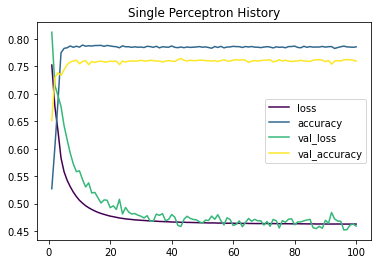

In [165]:
# Plot the history
nn_history_plot = nn_history_df.plot(title = "Single Perceptron History",colormap= "viridis")

<AxesSubplot:>

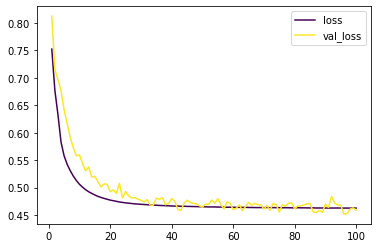

In [166]:
# Plot the loss
nn_history_df.plot(y=["loss", "val_loss"], colormap= "viridis")

<AxesSubplot:>

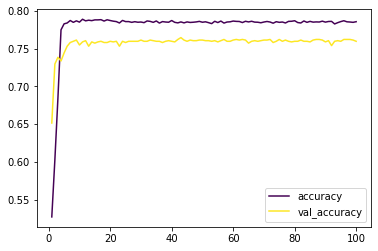

In [167]:
# Plot the accuracy
nn_history_df.plot(y=["accuracy", "val_accuracy"], colormap= "viridis")

In [168]:
# Evaluate the model using the test data
nn_model_loss,nn_model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=0)
print(f" The loss for the single perceptron model is: {nn_model_loss}, The accuracy is: {nn_model_accuracy}")

 The loss for the single perceptron model is: 0.45889559388160706, The accuracy is: 0.759772002696991


In [169]:
# Y_pred: flatten & convert prediction probabilities to binary format so it can be passed through confusion matrix
y_pred_nn = nn_model.predict(X_test_scaled)
y_pred_nn = y_pred_nn.flatten()
y_pred_nn_tf=tf.round(y_pred_nn)

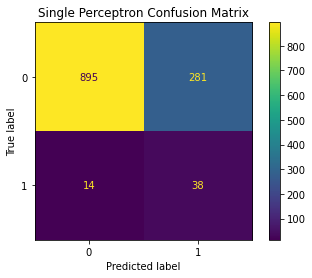

In [170]:
# Display the confusion matrix
nn_cm = confusion_matrix(y_test, y_pred_nn_tf)

nn_disp = ConfusionMatrixDisplay(confusion_matrix=nn_cm)
nn_disp.plot()
nn_disp.ax_.set_title("Single Perceptron Confusion Matrix")
nn_disp

In [171]:
# Advanced Classification Metrics
# Accuracy
nn_accuracy_score = accuracy_score(y_test, y_pred_nn_tf)
print(f'Accuracy Score of the Single Perceptron Model: {nn_accuracy_score}')

# Recall
nn_recall_score = recall_score(y_test, y_pred_nn_tf)
print(f'Recall Score of the Single Perceptron Model: {nn_recall_score}')

# Specificity
nn_specificity_score = 40 / (40+12)
print(f'Specifity Score of the Deep Learning Model: {nn_specificity_score}')

# Balanced Accuracy Score
nn_bas = balanced_accuracy_score(y_test, y_pred_nn_tf)
print(f'Balanced Accuracy Score of the Single Perceptron Model: {nn_bas}')

# Precision
nn_precision_score = precision_score(y_test, y_pred_nn_tf)
print(f'Precision Score of the Single Perceptron Model: {nn_precision_score}')     
   
# F1 Score
nn_f1_score = f1_score(y_test, y_pred_nn_tf)
print(f'F1 Score Score of the Single Perceptron Model: {nn_f1_score}')

# Loss Score
print(f'Loss of the Multiple Perceptron Model: {nn_model_loss}')

# Advanced Classification Metrics DF
nn_acm = {"Model Type": ["Single Perceptron"], "Accuracy":[nn_accuracy_score], "Recall": [nn_recall_score], "Specificity":[nn_specificity_score], 
          "Balanced Accuracy": [nn_bas], "Precision":[nn_precision_score], "F1 Score":[nn_f1_score], "Loss": [nn_model_loss]}
nn_acm_df = pd.DataFrame(data=nn_acm)
nn_acm_df

Accuracy Score of the Single Perceptron Model: 0.759771986970684
Recall Score of the Single Perceptron Model: 0.7307692307692307
Specifity Score of the Deep Learning Model: 0.7692307692307693
Balanced Accuracy Score of the Single Perceptron Model: 0.7459118262689691
Precision Score of the Single Perceptron Model: 0.11912225705329153
F1 Score Score of the Single Perceptron Model: 0.20485175202156333
Loss of the Multiple Perceptron Model: 0.45889559388160706


,Model Type,Accuracy,Recall,Specificity,Balanced Accuracy,Precision,F1 Score,Loss
0,Single Perceptron,0.759772,0.730769,0.769231,0.745912,0.119122,0.204852,0.458896


## Multiple Neuron Single Layer Neural Network

In [172]:
# Generate our new Sequential model
multi_nn_model = tf.keras.models.Sequential()

# Add the input and hidden layer
number_inputs = 21
number_hidden_nodes = 6

multi_nn_model.add(tf.keras.layers.Dense(units=number_hidden_nodes, activation="relu", input_dim=number_inputs))

# Add the output layer that uses a probability activation function
multi_nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

In [173]:
# Compile the Sequential model together and customize metrics
multi_nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [174]:
# Fit the model to the training data
fit_model_multi = multi_nn_model.fit(X_resampled, y_resampled, validation_data = (X_test_scaled, y_test), epochs=100, shuffle=True)

Epoch 1/100
221/221 [==============================] - 1s 2ms/step - loss: 0.6624 - accuracy: 0.6388 - val_loss: 0.6694 - val_accuracy: 0.6645
Epoch 2/100
221/221 [==============================] - 0s 1ms/step - loss: 0.5598 - accuracy: 0.7198 - val_loss: 0.5967 - val_accuracy: 0.6889
Epoch 3/100
221/221 [==============================] - 0s 1ms/step - loss: 0.5233 - accuracy: 0.7498 - val_loss: 0.5508 - val_accuracy: 0.7028
Epoch 4/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4982 - accuracy: 0.7658 - val_loss: 0.5161 - val_accuracy: 0.7199
Epoch 5/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4778 - accuracy: 0.7812 - val_loss: 0.4768 - val_accuracy: 0.7402
Epoch 6/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4627 - accuracy: 0.7862 - val_loss: 0.4450 - val_accuracy: 0.7565
Epoch 7/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4532 - accuracy: 0.7920 - val_loss: 0.4555 - val_accuracy: 0.7500

Epoch 58/100
221/221 [==============================] - 0s 1ms/step - loss: 0.3901 - accuracy: 0.8268 - val_loss: 0.4283 - val_accuracy: 0.7801
Epoch 59/100
221/221 [==============================] - 0s 1ms/step - loss: 0.3900 - accuracy: 0.8292 - val_loss: 0.4133 - val_accuracy: 0.7875
Epoch 60/100
221/221 [==============================] - 0s 1ms/step - loss: 0.3896 - accuracy: 0.8285 - val_loss: 0.4137 - val_accuracy: 0.7883
Epoch 61/100
221/221 [==============================] - 0s 1ms/step - loss: 0.3891 - accuracy: 0.8271 - val_loss: 0.4131 - val_accuracy: 0.7907
Epoch 62/100
221/221 [==============================] - 0s 1ms/step - loss: 0.3888 - accuracy: 0.8313 - val_loss: 0.4295 - val_accuracy: 0.7818
Epoch 63/100
221/221 [==============================] - 0s 1ms/step - loss: 0.3885 - accuracy: 0.8297 - val_loss: 0.4454 - val_accuracy: 0.7744
Epoch 64/100
221/221 [==============================] - 0s 1ms/step - loss: 0.3886 - accuracy: 0.8279 - val_loss: 0.4234 - val_accuracy:

In [175]:
# Create a DataFrame containing training history
multi_history_df = pd.DataFrame(fit_model_multi.history, index=range(1,len(fit_model_multi.history["loss"])+1))
multi_history_df

,loss,accuracy,val_loss,val_accuracy
1,0.662396,0.638834,0.669414,0.664495
2,0.559814,0.719785,0.596671,0.688925
3,0.523306,0.749788,0.550827,0.702769
4,0.498184,0.765780,0.516085,0.719870
5,0.477844,0.781206,0.476850,0.740228
...,...,...,...,...
96,0.378712,0.837390,0.411204,0.807003
97,0.378150,0.834701,0.411148,0.804560
98,0.378121,0.834843,0.413405,0.806189
99,0.378330,0.834843,0.417319,0.802117


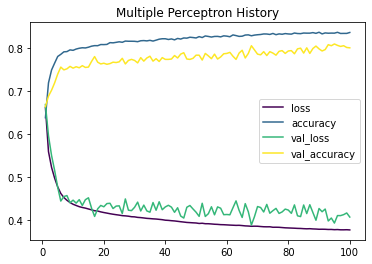

In [176]:
# Plot the history
multi_history_plotf = multi_history_df.plot(title = "Multiple Perceptron History",colormap= "viridis")

<AxesSubplot:>

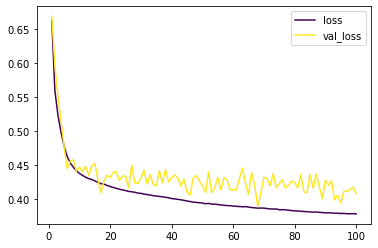

In [177]:
# Plot the loss
multi_history_df.plot(y=["loss", "val_loss"], colormap= "viridis")

<AxesSubplot:>

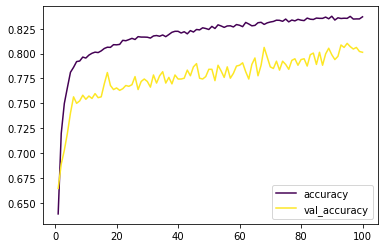

In [178]:
# Plot the accuracy
multi_history_df.plot(y=["accuracy", "val_accuracy"], colormap= "viridis")

In [179]:
# Evaluate the model using the test data
multi_model_loss, multi_model_accuracy = multi_nn_model.evaluate(X_test_scaled,y_test,verbose=0)
print(f" The loss for the multiple perceptron model is: {multi_model_loss}, The accuracy is: {multi_model_accuracy}")

 The loss for the multiple perceptron model is: 0.40779128670692444, The accuracy is: 0.8013029098510742


In [180]:
#Y_pred: flatten & Convert prediction probabilities to binary format
y_pred_multi = multi_nn_model.predict(X_test_scaled)
y_pred_multi = y_pred_multi.flatten()
y_pred_multi_tf = tf.round(y_pred_multi)

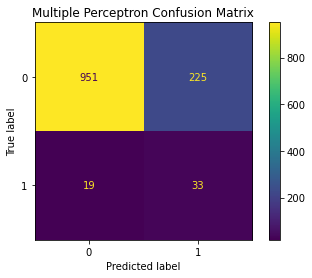

In [181]:
# Display the confusion matrix
multi_nn_cm = confusion_matrix(y_test, y_pred_multi_tf)

multi_disp = ConfusionMatrixDisplay(confusion_matrix=multi_nn_cm)
multi_disp.plot()
multi_disp.ax_.set_title("Multiple Perceptron Confusion Matrix")
multi_disp

In [182]:
# Advanced Classification Metrics
# Accuracy
multi_accuracy_score = accuracy_score(y_test, y_pred_multi_tf)
print(f'Accuracy Score of the Multiple Perceptron Model: {multi_accuracy_score}')

# Recall/ Sensitivity
multi_recall_score = recall_score(y_test, y_pred_multi_tf)
print(f'Recall Score of the Multiple Perceptron Model: {multi_recall_score}')

# Specificity
multi_specificity_score = 35 / (35+17)
print(f'Specifity Score of the Deep Learning Model: {multi_specificity_score}')

# Balanced Accuracy Score
multi_bas = balanced_accuracy_score(y_test, y_pred_multi_tf)
print(f'Balanced Accuracy Score of the Multiple Perceptron Model: {multi_bas}')

# Precision
multi_precision_score = precision_score(y_test, y_pred_multi_tf)
print(f'Precision Score of the Multiple Perceptron Model: {multi_precision_score}')     
      
# F1 Score
multi_f1_score = f1_score(y_test, y_pred_multi_tf)
print(f'F1 Score Score of the Multiple Perceptron Model: {multi_f1_score}')

# Loss Score
print(f'Loss of the Multiple Perceptron Model: {multi_model_loss}')

# Advanced Classification Metrics DF
multi_acm = {"Model Type": ["Multi Perceptron"], "Accuracy":[multi_accuracy_score], "Recall": [multi_recall_score], "Specificity":[multi_specificity_score], 
          "Balanced Accuracy": [multi_bas], "Precision":[multi_precision_score], "F1 Score":[multi_f1_score], "Loss": [multi_model_loss]}
multi_acm_df = pd.DataFrame(data=multi_acm)
multi_acm_df

Accuracy Score of the Multiple Perceptron Model: 0.8013029315960912
Recall Score of the Multiple Perceptron Model: 0.6346153846153846
Specifity Score of the Deep Learning Model: 0.6730769230769231
Balanced Accuracy Score of the Multiple Perceptron Model: 0.7216444270015698
Precision Score of the Multiple Perceptron Model: 0.12790697674418605
F1 Score Score of the Multiple Perceptron Model: 0.21290322580645163
Loss of the Multiple Perceptron Model: 0.40779128670692444


,Model Type,Accuracy,Recall,Specificity,Balanced Accuracy,Precision,F1 Score,Loss
0,Multi Perceptron,0.801303,0.634615,0.673077,0.721644,0.127907,0.212903,0.407791


## Deep Learning Neural Network

In [183]:
# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 50

deep_nn_model = tf.keras.models.Sequential()

# First hidden layer
deep_nn_model.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
deep_nn_model.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
deep_nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
deep_nn_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 80)                1760      
                                                                 
 dense_26 (Dense)            (None, 50)                4050      
                                                                 
 dense_27 (Dense)            (None, 1)                 51        
                                                                 
Total params: 5,861
Trainable params: 5,861
Non-trainable params: 0
_________________________________________________________________


In [184]:
# Compile the model
deep_nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [185]:
# Train the model
fit_model_deep = deep_nn_model.fit(X_train_scaled, y_train, validation_data = (X_test_scaled, y_test), epochs=100)

Epoch 1/100
116/116 [==============================] - 1s 2ms/step - loss: 0.1860 - accuracy: 0.9568 - val_loss: 0.1556 - val_accuracy: 0.9577
Epoch 2/100
116/116 [==============================] - 0s 2ms/step - loss: 0.1491 - accuracy: 0.9573 - val_loss: 0.1458 - val_accuracy: 0.9577
Epoch 3/100
116/116 [==============================] - 0s 2ms/step - loss: 0.1424 - accuracy: 0.9576 - val_loss: 0.1453 - val_accuracy: 0.9577
Epoch 4/100
116/116 [==============================] - 0s 2ms/step - loss: 0.1380 - accuracy: 0.9579 - val_loss: 0.1410 - val_accuracy: 0.9593
Epoch 5/100
116/116 [==============================] - 0s 2ms/step - loss: 0.1357 - accuracy: 0.9576 - val_loss: 0.1421 - val_accuracy: 0.9593
Epoch 6/100
116/116 [==============================] - 0s 2ms/step - loss: 0.1336 - accuracy: 0.9579 - val_loss: 0.1421 - val_accuracy: 0.9593
Epoch 7/100
116/116 [==============================] - 0s 3ms/step - loss: 0.1332 - accuracy: 0.9579 - val_loss: 0.1462 - val_accuracy: 0.9585

Epoch 58/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0798 - accuracy: 0.9709 - val_loss: 0.2169 - val_accuracy: 0.9503
Epoch 59/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0711 - accuracy: 0.9742 - val_loss: 0.2147 - val_accuracy: 0.9463
Epoch 60/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0722 - accuracy: 0.9723 - val_loss: 0.2210 - val_accuracy: 0.9528
Epoch 61/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0704 - accuracy: 0.9720 - val_loss: 0.2162 - val_accuracy: 0.9422
Epoch 62/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0779 - accuracy: 0.9690 - val_loss: 0.2149 - val_accuracy: 0.9511
Epoch 63/100
116/116 [==============================] - 0s 3ms/step - loss: 0.0708 - accuracy: 0.9731 - val_loss: 0.2282 - val_accuracy: 0.9536
Epoch 64/100
116/116 [==============================] - 0s 4ms/step - loss: 0.0689 - accuracy: 0.9731 - val_loss: 0.2185 - val_accuracy:

In [186]:
# Create a DataFrame containing training history
deep_history_df = pd.DataFrame(fit_model_deep.history, index=range(1,len(fit_model_deep.history["loss"])+1))
deep_history_df

,loss,accuracy,val_loss,val_accuracy
1,0.186031,0.956805,0.155641,0.957655
2,0.149089,0.957349,0.145778,0.957655
3,0.142355,0.957620,0.145315,0.957655
4,0.138049,0.957892,0.141013,0.959283
5,0.135717,0.957620,0.142084,0.959283
...,...,...,...,...
96,0.050524,0.979082,0.306778,0.951140
97,0.050119,0.980168,0.310923,0.952769
98,0.048547,0.982342,0.308766,0.947068
99,0.047102,0.981255,0.313006,0.950326


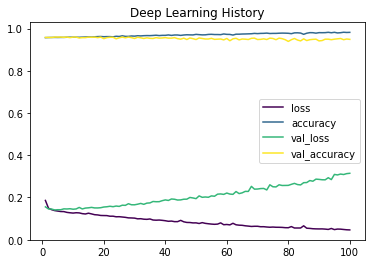

In [187]:
#Plot the history
deep_history_plot = deep_history_df.plot(title = "Deep Learning History",colormap= "viridis")


<AxesSubplot:>

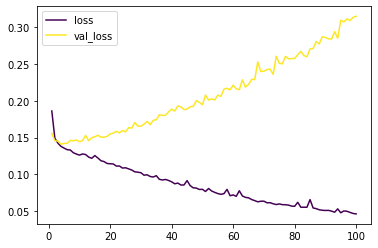

In [188]:
# Plot the loss
deep_history_df.plot(y=["loss", "val_loss"], colormap= "viridis")

<AxesSubplot:>

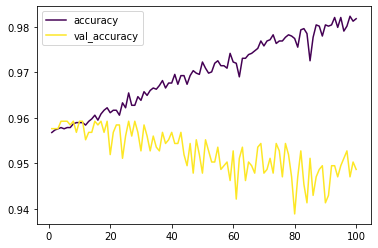

In [189]:
# Plot the accuracy
deep_history_df.plot(y=["accuracy", "val_accuracy"], colormap= "viridis")

In [190]:
# Evaluate the model using the test data
dl_model_loss, dl_model_accuracy = deep_nn_model.evaluate(X_test_scaled,y_test,verbose=0)
print(f" The loss for the deep learning model is: {dl_model_loss}, The accuracy is: {dl_model_accuracy}")

 The loss for the deep learning model is: 0.31454071402549744, The accuracy is: 0.9486970901489258


In [191]:
#Y_pred: flatten & Convert prediction probabilities to binary format
y_pred_dl = deep_nn_model.predict(X_test_scaled)
y_pred_dl = y_pred_dl.flatten()
y_pred_dl_tf=tf.round(y_pred_dl)

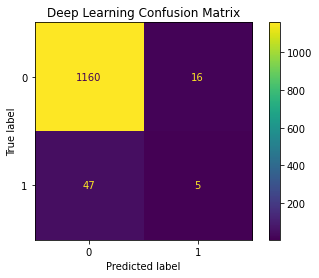

In [192]:
# Display the confusion matrix
dl_nn_cm = confusion_matrix(y_test, y_pred_dl_tf)
dl_disp = ConfusionMatrixDisplay(confusion_matrix=dl_nn_cm)
dl_disp.plot()
dl_disp.ax_.set_title("Deep Learning Confusion Matrix")
dl_disp

In [193]:
# Advanced Classification Metrics
# Accuracy
dl_accuracy_score = accuracy_score(y_test, y_pred_dl_tf)
print(f'Accuracy Score of the Deep Learning Model: {dl_accuracy_score}')

## Recall/Sensitivity
dl_recall_score = recall_score(y_test, y_pred_dl_tf)
print(f'Recall Score of the Deep Learning Model: {dl_recall_score}')

# Specificity
dl_specificity_score = 4 / (4+48)
print(f'Specifity Score of the Deep Learning Model: {dl_specificity_score}')

# Balanced Accuracy Score
dl_bas = balanced_accuracy_score(y_test, y_pred_dl_tf)
print(f'Balanced Accuracy Score of the Multiple Perceptron Model: {dl_bas}')

# Precision
dl_precision_score = precision_score(y_test, y_pred_dl_tf)
print(f'Precision Score of the Deep Learning Model: {dl_precision_score}')     
      
# F1 Score
dl_f1_score = f1_score(y_test, y_pred_dl_tf)
print(f'F1 Score Score of the Deep Learning Model: {dl_f1_score}')

# Loss Score
print(f'Loss of the Deep Learning Model: {dl_model_loss}')

# Advanced Classification Metrics DF
dl_acm = {"Model Type": ["Deep Learning"], "Accuracy":[dl_accuracy_score], "Recall": [dl_recall_score], "Specificity":[dl_specificity_score], 
          "Balanced Accuracy": [dl_bas], "Precision":[dl_precision_score], "F1 Score":[dl_f1_score], "Loss": [dl_model_loss]}
dl_acm_df = pd.DataFrame(data=dl_acm)
dl_acm_df

Accuracy Score of the Deep Learning Model: 0.9486970684039088
Recall Score of the Deep Learning Model: 0.09615384615384616
Specifity Score of the Deep Learning Model: 0.07692307692307693
Balanced Accuracy Score of the Multiple Perceptron Model: 0.5412742019884877
Precision Score of the Deep Learning Model: 0.23809523809523808
F1 Score Score of the Deep Learning Model: 0.136986301369863
Loss of the Deep Learning Model: 0.31454071402549744


,Model Type,Accuracy,Recall,Specificity,Balanced Accuracy,Precision,F1 Score,Loss
0,Deep Learning,0.948697,0.096154,0.076923,0.541274,0.238095,0.136986,0.314541


## Comparison of the Models

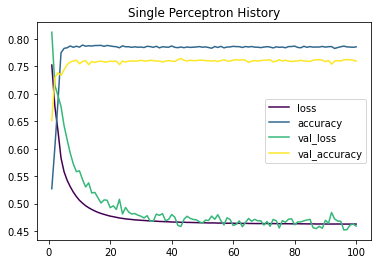

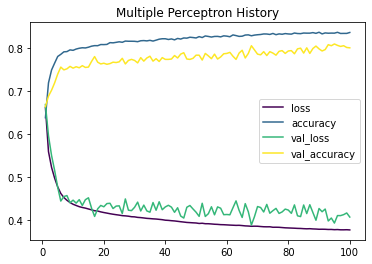

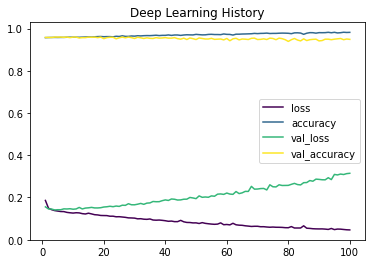

In [194]:
nn_history_plot = nn_history_df.plot(title = "Single Perceptron History",colormap= "viridis")
multi_history_plotf = multi_history_df.plot(title = "Multiple Perceptron History",colormap= "viridis")
deep_history_plot = deep_history_df.plot(title = "Deep Learning History",colormap= "viridis")

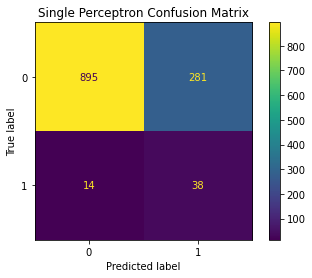

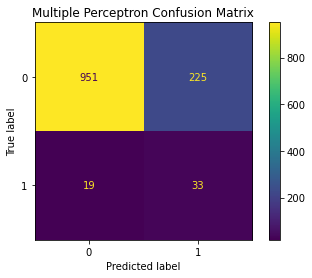

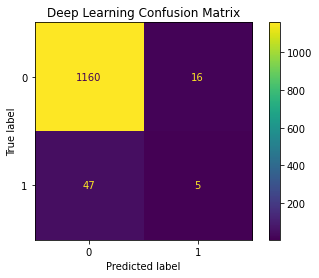

In [195]:
# Single Perceptron Confusion Matrix
nn_disp.plot()
nn_disp.ax_.set_title("Single Perceptron Confusion Matrix")

# Multiple Perceptron Confusion Matrix
multi_disp.plot()
multi_disp.ax_.set_title("Multiple Perceptron Confusion Matrix")

# Deep Learning Confusion Matrix
dl_disp.plot()
dl_disp.ax_.set_title("Deep Learning Confusion Matrix")
dl_disp

In [196]:
# Total Advanced Classification Metrics DF
total_acm = ({"Model Type": "Single Perceptron", "Accuracy":nn_accuracy_score, "Recall": nn_recall_score, "Specificity":nn_specificity_score, 
          "Balanced Accuracy": nn_bas, "Precision":nn_precision_score, "F1 Score":nn_f1_score, "Loss": nn_model_loss }, {"Model Type": "Multi Perceptron", "Accuracy":multi_accuracy_score, "Recall": multi_recall_score, "Specificity":multi_specificity_score, 
          "Balanced Accuracy": multi_bas, "Precision":multi_precision_score, "F1 Score":multi_f1_score, "Loss": multi_model_loss}, {"Model Type": "Deep Learning", "Accuracy":dl_accuracy_score, "Recall": dl_recall_score, "Specificity":dl_specificity_score, 
          "Balanced Accuracy": dl_bas, "Precision":dl_precision_score, "F1 Score":dl_f1_score, "Loss": dl_model_loss})
total_acm_df = pd.DataFrame(data=total_acm)
total_acm_df

,Model Type,Accuracy,Recall,Specificity,Balanced Accuracy,Precision,F1 Score,Loss
0,Single Perceptron,0.759772,0.730769,0.769231,0.745912,0.119122,0.204852,0.458896
1,Multi Perceptron,0.801303,0.634615,0.673077,0.721644,0.127907,0.212903,0.407791
2,Deep Learning,0.948697,0.096154,0.076923,0.541274,0.238095,0.136986,0.314541
